### Let's first import all the libraries that we will need

In [1]:
## Link:   https://www.kaggle.com/c/competitive-data-science-predict-future-sales

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from itertools import product


Using TensorFlow backend.


In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype#.name
        
        if col_type != object and col_type.name != 'category' :
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Part 1: Importing the data and visualizing it

In [3]:
item_categories=pd.read_csv("item_categories.csv")
items=pd.read_csv("items.csv")
sales_train=pd.read_csv("sales_train.csv")
sales_train=reduce_mem_usage(sales_train)
sample_submission=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

Memory usage of dataframe is 134.39 MB
Memory usage after optimization is: 33.65 MB
Decreased by 75.0%


In [4]:
print("There are",item_categories.item_category_id.count(),"categories of items")

print(item_categories.head())

## We check if we have any duplicates in the item category name, we see that we don't have any
print(item_categories[item_categories.item_category_name.duplicated()==True])

There are 84 categories of items
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
Empty DataFrame
Columns: [item_category_name, item_category_id]
Index: []


### We can see in the histogram below that the item category 40 has the most items in it and that some categories don't have any items at all

The number of items is 22170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


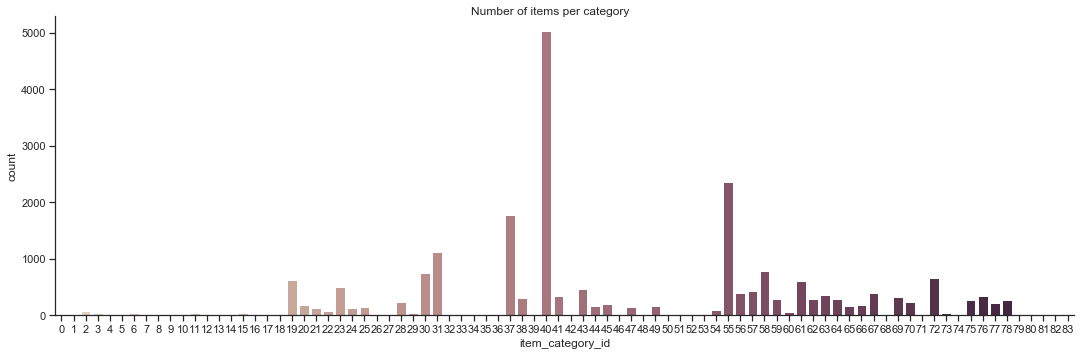

In [4]:
print("The number of items is",items.item_id.count())
sns.catplot(x="item_category_id", kind="count", palette="ch:.25", data=items,height=5,aspect=3).fig.suptitle("Number of items per category")
items.head()


In [55]:
print("The number of shops is", shops.shop_id.count())
print(shops.head())
## Let's see if we have duplicated shop names, it seems that we don't; we have to note that the shop names 
## are in cyrillic which makes their analysis harder :
shops[shops.shop_name.duplicated()]

The number of shops is 60
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


,shop_name,shop_id


### First we notice that we have an item that have a negative price, there's only one instance of it and we remove it from sales since it's an outlier. We also notice that we have some increadibly high prices, and we see in the boxplot that these prices are outliers and should be removed 

In [6]:
print("the number of transactions is",sales_train.item_cnt_day.count(),"\n")
sales_train.head()

the number of transactions is 2935849 



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


C:\Users\Ghassen Cherni\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


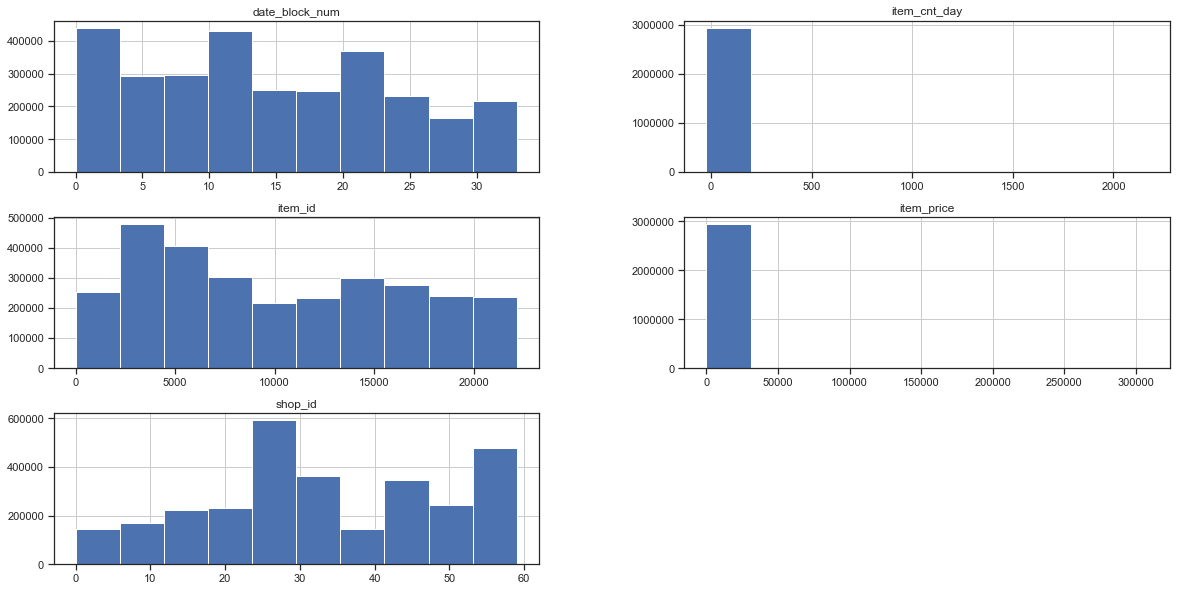

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
sales_train.hist(ax=ax) 
sales_train.describe()


In [5]:
#Let's remove the transaction with the negative item price
item_id=sales_train[sales_train.item_price==-1].item_id
items[items.item_id==item_id.values[0]]
sales_train=sales_train[sales_train.item_price != -1]

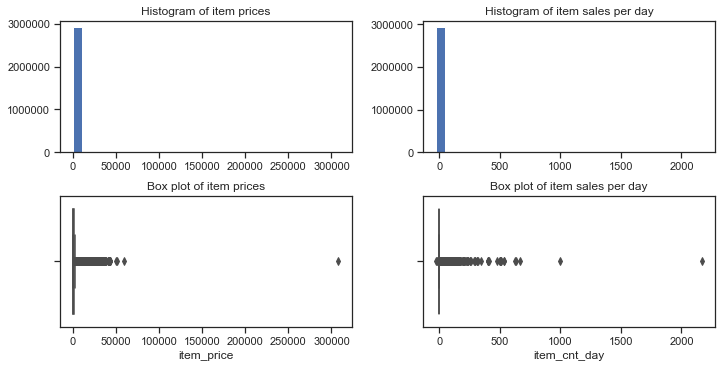

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, constrained_layout=True,figsize=(10, 5))

axs[0,0].hist(sales_train.item_price,bins=30);
axs[0,0].set_title('Histogram of item prices')
sns.boxplot(x=sales_train["item_price"],ax=axs[1,0]).set_title("Box plot of item prices");

axs[0,1].hist(sales_train.item_cnt_day,bins=30);
axs[0,1].set_title('Histogram of item sales per day')
sns.boxplot(x=sales_train["item_cnt_day"],ax=axs[1,1]).set_title("Box plot of item sales per day");

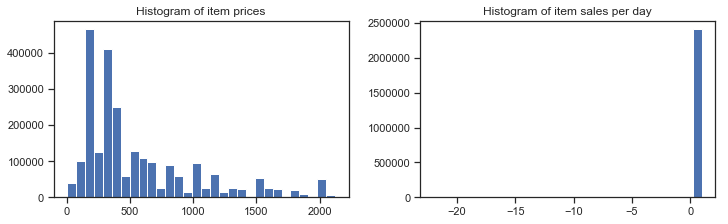

In [4]:
# Let's remove the outliers:
(upper_quartile_sales,upper_quartile_count) = (np.percentile(sales_train.item_price, 75)
                                               ,np.percentile(sales_train.item_cnt_day, 75))
(lower_quartile_sales,lower_quartile_count) = (np.percentile(sales_train.item_price, 25),
                                               np.percentile(sales_train.item_cnt_day, 25))

(iqr_sales,iqr_count) = (upper_quartile_sales - lower_quartile_sales,upper_quartile_count - lower_quartile_count)

upper_whisker_sales = sales_train.item_price[sales_train.item_price<=upper_quartile_sales+1.5*iqr_sales].max()
lower_whisker_sales = sales_train.item_price[sales_train.item_price>=lower_quartile_sales-1.5*iqr_sales].min()

upper_whisker_count = sales_train.item_cnt_day[sales_train.item_cnt_day<=upper_quartile_count+1.5*iqr_count].max()
lower_whisker_count = sales_train.item_cnt_day[sales_train.item_cnt_day>=lower_quartile_count-1.5*iqr_count].min()

sales_train=sales_train[(sales_train.item_price<=upper_whisker_sales) & (sales_train.item_price>=lower_whisker_sales)
                       & (sales_train.item_cnt_day<=upper_whisker_count) & (sales_train.item_price>=lower_whisker_count)]

fig, axs = plt.subplots(1,2, constrained_layout=True,figsize=(10, 3))
axs[0].hist(sales_train.item_price,bins=30);
axs[0].set_title('Histogram of item prices');
axs[1].hist(sales_train.item_cnt_day,bins=30);
axs[1].set_title('Histogram of item sales per day');

Sample submission file 
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5 

test file
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


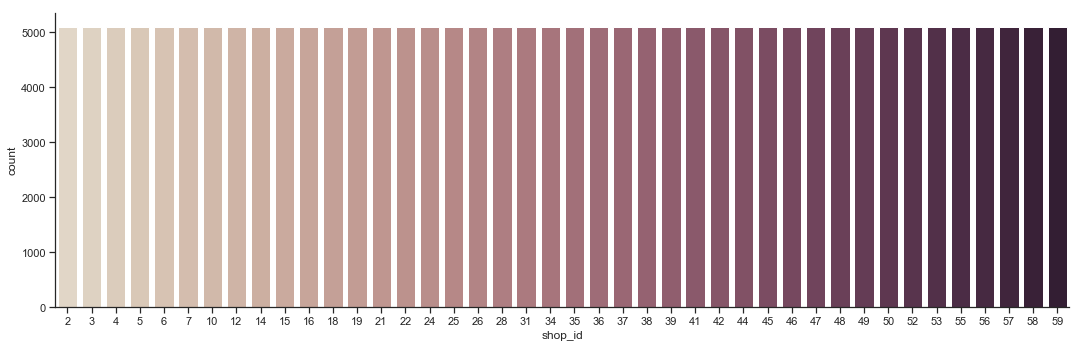

In [72]:
print("Sample submission file ")
print(sample_submission.head(), "\n")
print("test file")
print(test.head())
sns.catplot(x="shop_id", kind="count", palette="ch:.25", data=test,height=5,aspect=3)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,20.01.2013,0,27,22154,999.0,1.0,37
3,02.01.2013,0,25,22154,999.0,1.0,37
4,03.01.2013,0,25,22154,999.0,1.0,37


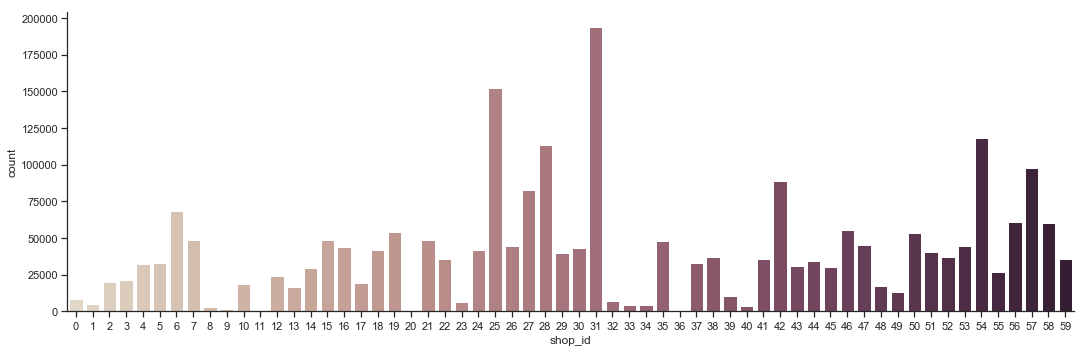

In [6]:
df=sales_train.merge(items,on="item_id").drop("item_name",axis=1)
sns.catplot(x="shop_id", kind="count", palette="ch:.25", data=df,height=5,aspect=3)

df.head()

## Now let's start feature engineering

In [7]:
df['date'] = pd.to_datetime(df['date'],format='%d.%m.%Y')

In [8]:
df["year"]=df.date.dt.year
df["month"]=df.date.dt.month
df.drop(["date"],axis=1,inplace=True)
df.head()
sales=df.groupby(["year","month","date_block_num","shop_id","item_id","item_price","item_category_id"],as_index=False)["item_cnt_day"].sum()
sales.head()

,year,month,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day
0,2013,1,0,0,32,221.0,40,2.0
1,2013,1,0,0,33,347.0,37,3.0
2,2013,1,0,0,35,247.0,40,1.0
3,2013,1,0,0,43,221.0,40,1.0
4,2013,1,0,0,51,127.0,57,1.0


In [9]:
sales.describe()

,year,month,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day
count,1.559320e+06,1.559320e+06,1.559320e+06,1.559320e+06,1.559320e+06,1.559320e+06,1.559320e+06,1559320.0
mean,2.013778e+03,6.113951e+00,1.445457e+01,3.289685e+01,1.079799e+04,5.393515e+02,4.200297e+01,NaN
std,7.746465e-01,3.441867e+00,9.518819e+00,1.648821e+01,6.250048e+03,4.680392e+02,1.550325e+01,0.0
min,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-22.0
25%,2.013000e+03,3.000000e+00,6.000000e+00,2.100000e+01,5.133000e+03,1.990000e+02,3.000000e+01,1.0
50%,2.014000e+03,6.000000e+00,1.300000e+01,3.100000e+01,1.070100e+04,3.490000e+02,4.000000e+01,1.0
75%,2.014000e+03,9.000000e+00,2.200000e+01,4.700000e+01,1.615600e+04,6.990000e+02,5.500000e+01,2.0
max,2.015000e+03,1.200000e+01,3.300000e+01,5.900000e+01,2.216800e+04,2.124000e+03,8.300000e+01,19.0


In [57]:
# date_block=np.arange(0,34)
# shop_id=sales.shop_id.unique()
# item_id=sales.item_id.unique()
# crossJoined=np.array(list(product(date_block,shop_id,item_id)))
# crossJoined
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sale = sales[sales.date_block_num==i]
    matrix.append(np.array(list(product([i], sale.shop_id.unique(), sale.item_id.unique()))))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num']
# matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
# matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix=matrix.merge(sales,how="left",on=cols)
matrix=reduce_mem_usage(matrix)


In [58]:
dict_year=pd.Series(sales.year.values ,index=sales.date_block_num.values).to_dict()
dict_month=pd.Series(sales.month.values ,index=sales.date_block_num.values).to_dict()
dict_category=pd.Series(items.item_category_id.values ,index=items.item_id.values).to_dict()

matrix["year"] = matrix['date_block_num'].replace(dict_year)
matrix['month']=matrix['date_block_num'].replace(dict_month)
matrix["item_category_id"] = matrix.groupby("item_id")["item_category_id"].transform(lambda x: x.fillna(x.mean()))
matrix['item_cnt_day']=matrix['item_cnt_day'].fillna(0)

## A modifier probablement
matrix["item_price"] = matrix.groupby("item_id")["item_price"].transform(lambda x: x.fillna(x.mean()))
matrix['item_cnt_day']=matrix['item_cnt_day'].clip(0,20)
matrix['item_cnt_day']=matrix['item_cnt_day'].astype(np.float64)

In [69]:
matrix['item_cnt_day']=matrix['item_cnt_day'].astype(np.float64)
matrix.head()


,date_block_num,shop_id,item_id,year,month,item_price,item_category_id,item_cnt_day
0,0,0,19,2013,1,28.000000,40.0,0.0
1,0,0,27,2013,1,1320.989189,19.0,0.0
2,0,0,28,2013,1,300.363514,30.0,0.0
3,0,0,29,2013,1,1348.333333,23.0,0.0
4,0,0,32,2013,1,221.000000,40.0,2.0


In [60]:
matrix.describe()

,date_block_num,shop_id,item_id,year,month,item_price,item_category_id,item_cnt_day
count,1.046925e+07,1.046925e+07,1.046925e+07,1.046925e+07,1.046925e+07,1.046925e+07,1.046925e+07,10469248.0
mean,1.478617e+01,3.119561e+01,1.140798e+04,2.013802e+03,6.162754e+00,4.823974e+02,4.498824e+01,NaN
std,9.453827e+00,1.733928e+01,6.204863e+03,7.739819e-01,3.385273e+00,4.439748e+02,1.445663e+01,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.0
25%,7.000000e+00,1.600000e+01,6.122000e+03,2.013000e+03,3.000000e+00,1.920000e+02,3.700000e+01,0.0
50%,1.400000e+01,3.000000e+01,1.150400e+04,2.014000e+03,6.000000e+00,2.990000e+02,4.000000e+01,0.0
75%,2.200000e+01,4.600000e+01,1.672500e+04,2.014000e+03,9.000000e+00,5.990000e+02,5.500000e+01,0.0
max,3.300000e+01,5.900000e+01,2.216800e+04,2.015000e+03,1.200000e+01,2.124000e+03,8.300000e+01,19.0


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))


X=matrix.drop(["item_cnt_day"],axis=1)
#X=scaler1.fit_transform(X)
y=matrix[["item_cnt_day"]]
#y=scaler2.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=False)
X_train=scaler1.fit_transform(X_train)
X_test=scaler1.transform(X_test)
y_train=scaler2.fit_transform(y_train)
y_test=scaler2.transform(y_test)


In [24]:
matrix.head()

,date_block_num,shop_id,item_id,year,month,item_price,item_category_id,item_cnt_day
0,0,0,19,2013,1,28.000000,40.0,0.0
1,0,0,27,2013,1,1320.989189,19.0,0.0
2,0,0,28,2013,1,300.363514,30.0,0.0
3,0,0,29,2013,1,1348.333333,23.0,0.0
4,0,0,32,2013,1,221.000000,40.0,2.0


## Here we select our model and test different parameters to find the best hyperparameters

In [26]:
from lightgbm import LGBMRegressor

parameters={
    'n_estimators': [1,10,100],
    'max_depth':[1,10,100],
    'min_child_weight':[1,10,100,1000],
    'learning_rate': [0.01, 0.1, 1],
}
model = LGBMRegressor(max_depth=3,n_estimators=100)
#gbm = GridSearchCV(model, parameters, cv=3);
model.fit(X_train, y_train);
y_pred=model.predict(X_test)
y_test2=scaler2.inverse_transform(y_test)
y_pred = scaler2.inverse_transform(y_pred.reshape(3454852    , 1))
mean_squared_error(y_test2, y_pred)


C:\Users\Ghassen Cherni\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3785939790021329

In [29]:
test_merge=test.merge(items,on=['item_id']).drop(columns=['item_name'])
test_merge=test_merge.merge(matrix,on=["item_id","shop_id","item_category_id"],how='left').drop(
    columns=['year','month','date_block_num','item_cnt_day'])
test_merge
test_merge=test_merge.fillna(test_merge.mean())
#test_merge=test_merge.groupby("item_category_id").transform(lambda x: x.fillna(x.mean()))
test_merge['year']=2015
test_merge['month']=11
test_merge['date_block_num']=34
test_merge.drop_duplicates(inplace=True)
test_merge=test_merge.groupby(['shop_id','item_id','item_category_id','year','month','date_block_num','ID'])['item_price'].mean().reset_index()
test_merge.head()


,shop_id,item_id,item_category_id,year,month,date_block_num,ID,item_price
0,2,30,40,2015,11,34,22987,297.795159
1,2,31,37,2015,11,34,20994,544.549467
2,2,32,40,2015,11,34,20995,163.455382
3,2,33,37,2015,11,34,22492,314.305210
4,2,38,41,2015,11,34,22491,1574.462494


## Next we predict the set that we will submit for the kaggle competition

In [31]:
X=test_merge.drop(columns='ID')
scaler3 = MinMaxScaler(feature_range=(0, 1))
X=scaler3.fit_transform(X)
y_pred=model.predict(X)

In [34]:
y_pred

array([[0.54924294],
       [0.40580052],
       [0.40580052],
       ...,
       [0.37670166],
       [0.21582874],
       [0.24524903]])

In [33]:
y_pred=scaler2.inverse_transform(y_pred.reshape(214200, 1))

test_merge['item_cnt_month']=y_pred

In [35]:
submission=test_merge[['ID',"item_cnt_month"]]
submission.head()
submission.to_csv('submission.csv', index=False)
